In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import os

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42

# 현재 device 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
DATA_PATH = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [5]:
DATA_PATH_model = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [6]:
df = pd.read_csv(f"{DATA_PATH}train_emotion.csv")
df

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,시원하고 좋은데 뾰루지 많이나고 따갑네요,1,23.09.07.,라보에이치,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,저랑은 안맞네요 계속 쓰다보니 두피 너무 가렵고 비듬각질이 생기네요,1,23.02.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,효과는없고 계속많이빠져요,1,22.07.27.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,"제품이 어떤지는 잘 모르겠고요, 아모레퍼시픽이 소비자 생각 안 하는 회사인 건 확실...",1,22.04.05.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,ㅋㅋ최악이에요 진짜.. 3월1일에 주문했는데 3월 30일인 오늘 도착했네요 그냥 취...,1,22.03.30.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4731,머리빠짐이 덜한것 같은데 일단 더 사용해 볼게요~ 무엇보다 샴푸를 쓰고 나면 타샴푸...,5,21.11.25.,반코르,NaN,NaN,1.0,1.0,NaN,NaN,1.0
4732,확실히 기름기랑 두피여드름이 줄었어요,5,22.01.12.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4733,1. 머리 덜 간지러움 2. 각질 비듬 줄어듬 3. 머리카락이 두꺼워지는게 느껴짐 ...,5,21.12.12.,반코르,NaN,NaN,NaN,1.0,NaN,1.0,NaN
4734,지성두피라서 오후만 되면 앞머리 떡지던 사람으로서 이정도로 만족스러운 샴푸는 처음입...,5,21.12.01.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [7]:
df = df.dropna(subset='배송/서비스/고객대응', axis=0).reset_index(drop=True)

In [8]:
df

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,"제품이 어떤지는 잘 모르겠고요, 아모레퍼시픽이 소비자 생각 안 하는 회사인 건 확실...",1,22.04.05.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,ㅋㅋ최악이에요 진짜.. 3월1일에 주문했는데 3월 30일인 오늘 도착했네요 그냥 취...,1,22.03.30.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,배송개늦음 일욜 시켜서 토욜 받음,1,22.03.18.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,처음왔을때 퍼프가 부러진채로 와서 연락달라고 했었는데 ㅠㅠ 확인을 못하신건지 아직도...,1,21.07.04.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,물건이 파손되서 교환밖에 안된다는 메세지를 받았고 제가 직접 교환 신청을 했는데 그...,1,20.07.10.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
564,신랑이 한번 써보더니 뭔가 머릿결이 윤기 나는것 같다고 매우 만족해 하네요! 배송 ...,5,22.08.03.,반코르,NaN,NaN,NaN,NaN,1.0,NaN,1.0
565,빠르게 배송이 온점. 사용여부는 더 써봐야 알듯함. 찬물로 헹굴시 머릿결이 뻣뻣해지...,5,22.08.21.,반코르,NaN,NaN,NaN,NaN,1.0,NaN,0.0
566,이건 한달 후기도 쓸껀데 재구매품입니다. 제가 여기 샴푸랑 트리트먼트를 구매 후 두...,5,22.06.22.,반코르,NaN,NaN,NaN,1.0,1.0,NaN,NaN
567,비탈모 남성 한달사용 후기입니다. 저는 다른분들에게 어릴적부터 죄송하게도 머리숱이 ...,5,22.05.19.,반코르,NaN,NaN,NaN,1.0,1.0,NaN,1.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   content      569 non-null    object 
 1   score        569 non-null    int64  
 2   date         569 non-null    object 
 3   brand        569 non-null    object 
 4   가격           105 non-null    float64
 5   세정력/거품       66 non-null     float64
 6   향기           51 non-null     float64
 7   트러블/진정       46 non-null     float64
 8   배송/서비스/고객대응  569 non-null    float64
 9   탈모 효과 및 쿨링감  28 non-null     float64
 10  머릿결*         45 non-null     float64
dtypes: float64(7), int64(1), object(3)
memory usage: 49.0+ KB


In [10]:
target = df.iloc[:,8].to_numpy().reshape(-1,1)
target

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [11]:
target = (target == 0).astype(int)

In [12]:
model_name = "jaehyeong/koelectra-base-v3-generalized-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [13]:
train_token = tokenizer(df['content'].tolist(), padding="max_length", max_length=512, truncation=True)

In [14]:
input_ids = np.array(train_token['input_ids'])
attention_mask = np.array(train_token['attention_mask'])
token_type_ids = np.array(train_token['token_type_ids'])

input_ids.shape, attention_mask.shape, token_type_ids.shape

((569, 512), (569, 512), (569, 512))

In [15]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, token_type_ids, y_1=None, y_2=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.y_1 = y_1


    def __len__(self):
        return self.input_ids.shape[0]

    def __getitem__(self, idx):
        item = {}
        item['input_ids'] = torch.tensor(self.input_ids[idx])
        item['attention_mask'] = torch.tensor(self.attention_mask[idx])
        item['token_type_ids'] = torch.tensor(self.token_type_ids[idx])
        if self.y_1 is not None:
            item['y_1'] = torch.Tensor(self.y_1[idx])

        return item

In [16]:
class Net(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.output_layer = torch.nn.Linear( self.model.config.hidden_size , 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        x = self.model(input_ids, attention_mask, token_type_ids)
        x = self.output_layer(x[0][:,0])
        return x

In [17]:
def train_loop(dataloader, model, bce_loss_fn, optimizer, device):
    epoch_loss = 0
    model.train() # 모델 객체를 학습모드로 전환
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # 이진분류 loss
        bce_loss = bce_loss_fn(pred, batch["y_1"].to(device))

        optimizer.zero_grad()
        bce_loss.backward()
        optimizer.step()

        epoch_loss += bce_loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

In [18]:
@torch.no_grad()
def test_loop(dataloader,model,bce_loss_fn, device):
    model.eval() # 평가 모드
    sig = torch.nn.Sigmoid()
    pred_1_list = []

    epoch_loss = 0
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # 검증 평가할 경우
        if batch.get("y_1") is not None:
            bce_loss = bce_loss_fn(pred, batch["y_1"].to(device))

            epoch_loss += bce_loss.item()

        # 예측값 만들기
        pred_1 = sig(pred).to("cpu").numpy()

        pred_1_list.append(pred_1)

    pred_1 = np.concatenate(pred_1_list)
    epoch_loss /= len(dataloader)
    return epoch_loss, pred_1

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score

batch_size = 4
bce_loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 100
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)

In [20]:
is_holdout = False
reset_seeds(SEED)
best_score_list = []
best_recall_score_list = []
best_precision_score_list = []

for i, (tri, vai) in enumerate(cv.split(input_ids, target)):
    model = Net(model_name).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    # 학습용
    train_dt = ReviewDataset(input_ids[tri], attention_mask[tri], token_type_ids[tri], target[tri])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)

    # 검증용
    valid_dt = ReviewDataset(input_ids[vai], attention_mask[vai], token_type_ids[vai], target[vai])
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size, shuffle=False)

    best_score = 0
    best_recall_score = 0
    best_precision_score = 0


    patience = 0
    for epoch in tqdm(range(epochs)):
        train_loss = train_loop(train_dl, model, bce_loss_fn, optimizer, device)
        valid_loss, pred= test_loop(valid_dl, model, bce_loss_fn, device)

        # multi-label Classification
        pred = (pred > 0.5).astype(int)
        f1 = f1_score(target[vai], pred)
        recall = recall_score(target[vai], pred)
        precision = precision_score(target[vai], pred)
        patience += 1

        if best_score < f1:
            patience = 0
            best_score = f1
            best_recall_score = recall
            best_precision_score = precision
            torch.save(model.state_dict(), f"{DATA_PATH_model}model_emotion_delivery_{i}.pth")

        print("f1_score_1:", f1)
        print("recall:", recall)
        print("precision:", precision)
        print("train_loss:", train_loss)
        print("valid_loss:", valid_loss)
        if patience == 5:
            break

    print(f"{i} 번째 폴드 best f1_score_1: {best_score}")
    print(f"{i} 번째 폴드 best recall_score: {best_recall_score}")
    print(f"{i} 번째 폴드 best precision_score: {best_precision_score}")
    best_score_list.append(best_score)
    best_recall_score_list.append(best_recall_score)
    best_precision_score_list.append(best_precision_score)
    if is_holdout:
        break

print(np.mean(best_score_list))
print(np.mean(best_recall_score_list))
print(np.mean(best_precision_score_list))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9473684210526316
recall: 0.9310344827586207
precision: 0.9642857142857143
train_loss: 0.3345302908044112
valid_loss: 0.1199500255029777


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9354838709677419
recall: 1.0
precision: 0.8787878787878788
train_loss: 0.11014973919577244
valid_loss: 0.09821211408566811


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9666666666666666
recall: 1.0
precision: 0.9354838709677419
train_loss: 0.042488444098189734
valid_loss: 0.08600299630378341


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9473684210526316
recall: 0.9310344827586207
precision: 0.9642857142857143
train_loss: 0.027288862095590224
valid_loss: 0.0878445758998137


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9473684210526316
recall: 0.9310344827586207
precision: 0.9642857142857143
train_loss: 0.021901941412994473
valid_loss: 0.0884382071391005


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9473684210526316
recall: 0.9310344827586207
precision: 0.9642857142857143
train_loss: 0.019987118716368026
valid_loss: 0.08381197372740455


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9655172413793104
recall: 0.9655172413793104
precision: 0.9655172413793104
train_loss: 0.018403276850126292
valid_loss: 0.07717913622839441


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9655172413793104
recall: 0.9655172413793104
precision: 0.9655172413793104
train_loss: 0.017779792103458914
valid_loss: 0.08056564530325604
0 번째 폴드 best f1_score_1: 0.9666666666666666
0 번째 폴드 best recall_score: 1.0
0 번째 폴드 best precision_score: 0.9354838709677419


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9666666666666666
recall: 1.0
precision: 0.9354838709677419
train_loss: 0.3048730229207298
valid_loss: 0.11899901740252972


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9508196721311475
recall: 1.0
precision: 0.90625
train_loss: 0.09689631608821321
valid_loss: 0.13478361208248754


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9333333333333333
recall: 0.9655172413793104
precision: 0.9032258064516129
train_loss: 0.057673704663389606
valid_loss: 0.10309537382924865


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9655172413793104
recall: 0.9655172413793104
precision: 0.9655172413793104
train_loss: 0.03150183490167061
valid_loss: 0.08435995904086478


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9666666666666666
recall: 1.0
precision: 0.9354838709677419
train_loss: 0.03506300124552166
valid_loss: 0.08094698270975516


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9666666666666666
recall: 1.0
precision: 0.9354838709677419
train_loss: 0.02007880679478771
valid_loss: 0.09308706482486992
1 번째 폴드 best f1_score_1: 0.9666666666666666
1 번째 폴드 best recall_score: 1.0
1 번째 폴드 best precision_score: 0.9354838709677419


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.8727272727272727
recall: 0.8571428571428571
precision: 0.8888888888888888
train_loss: 0.2846316277261889
valid_loss: 0.19229114697924976


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.8771929824561403
recall: 0.8928571428571429
precision: 0.8620689655172413
train_loss: 0.07378974717861989
valid_loss: 0.20037659887095977


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.896551724137931
recall: 0.9285714285714286
precision: 0.8666666666666667
train_loss: 0.03361010209967693
valid_loss: 0.2138926510795437


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.8771929824561403
recall: 0.8928571428571429
precision: 0.8620689655172413
train_loss: 0.03250891146282747
valid_loss: 0.23003618332461037


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.896551724137931
recall: 0.9285714285714286
precision: 0.8666666666666667
train_loss: 0.020822719147984396
valid_loss: 0.24015501339052772


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.8771929824561403
recall: 0.8928571428571429
precision: 0.8620689655172413
train_loss: 0.019411852105373616
valid_loss: 0.2673801823904545


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.896551724137931
recall: 0.9285714285714286
precision: 0.8666666666666667
train_loss: 0.02476964934663684
valid_loss: 0.2536869433483687


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.896551724137931
recall: 0.9285714285714286
precision: 0.8666666666666667
train_loss: 0.018559182099507826
valid_loss: 0.2751045776852246
2 번째 폴드 best f1_score_1: 0.896551724137931
2 번째 폴드 best recall_score: 0.9285714285714286
2 번째 폴드 best precision_score: 0.8666666666666667


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.8727272727272727
recall: 0.8571428571428571
precision: 0.8888888888888888
train_loss: 0.29643614181693184
valid_loss: 0.18700898579996209


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.896551724137931
recall: 0.9285714285714286
precision: 0.8666666666666667
train_loss: 0.11328206894298394
valid_loss: 0.1574380027515621


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.8928571428571429
recall: 0.8928571428571429
precision: 0.8928571428571429
train_loss: 0.06310687734533035
valid_loss: 0.15432974745936948


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.888888888888889
recall: 0.8571428571428571
precision: 0.9230769230769231
train_loss: 0.03420383491340959
valid_loss: 0.15874463504437228


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.888888888888889
recall: 0.8571428571428571
precision: 0.9230769230769231
train_loss: 0.012817687395829381
valid_loss: 0.17399444378880335


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.888888888888889
recall: 0.8571428571428571
precision: 0.9230769230769231
train_loss: 0.009085722447356634
valid_loss: 0.178094190930755


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9090909090909091
recall: 0.8928571428571429
precision: 0.9259259259259259
train_loss: 0.007088876069980886
valid_loss: 0.1859228839808754


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9056603773584904
recall: 0.8571428571428571
precision: 0.96
train_loss: 0.006348598813801481
valid_loss: 0.20926024688504122


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.888888888888889
recall: 0.8571428571428571
precision: 0.9230769230769231
train_loss: 0.004931680106541566
valid_loss: 0.216192717704087


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.888888888888889
recall: 0.8571428571428571
precision: 0.9230769230769231
train_loss: 0.004361913508833631
valid_loss: 0.22128494429514453


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9090909090909091
recall: 0.8928571428571429
precision: 0.9259259259259259
train_loss: 0.004216099550065242
valid_loss: 0.22501880293792306


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.888888888888889
recall: 0.8571428571428571
precision: 0.9230769230769231
train_loss: 0.029292567790355207
valid_loss: 0.23348038910550933
3 번째 폴드 best f1_score_1: 0.9090909090909091
3 번째 폴드 best recall_score: 0.8928571428571429
3 번째 폴드 best precision_score: 0.9259259259259259


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.962962962962963
recall: 0.9285714285714286
precision: 1.0
train_loss: 0.303659807008348
valid_loss: 0.11425171085986598


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9818181818181818
recall: 0.9642857142857143
precision: 1.0
train_loss: 0.1259483444063287
valid_loss: 0.060873477816067896


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.9433962264150945
recall: 0.8928571428571429
precision: 1.0
train_loss: 0.06389378325752261
valid_loss: 0.08660362898532686


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.962962962962963
recall: 0.9285714285714286
precision: 1.0
train_loss: 0.04898979785247592
valid_loss: 0.05454572193838399


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.962962962962963
recall: 0.9285714285714286
precision: 1.0
train_loss: 0.03705543934841428
valid_loss: 0.045631487131247234


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.962962962962963
recall: 0.9285714285714286
precision: 1.0
train_loss: 0.03035127766953226
valid_loss: 0.03789690307116714


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

f1_score_1: 0.962962962962963
recall: 0.9285714285714286
precision: 1.0
train_loss: 0.019495313880932435
valid_loss: 0.045733618020112145
4 번째 폴드 best f1_score_1: 0.9818181818181818
4 번째 폴드 best recall_score: 0.9642857142857143
4 번째 폴드 best precision_score: 1.0
0.944158829676071
0.9571428571428571
0.9327120669056154


In [21]:
DATA_PATH_test = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [22]:
test = pd.read_csv(f"{DATA_PATH_test}test_emotion.csv")
test

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,배송누락되어 본사확신다고 하시고 다시 주문번호 올려달라고 하시니 대응절차가 문제있어...,1,23.08.31.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,전에 쓰던 샴푸보다 머리카락 더빠짐…,1,23.03.25.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,사용감은 더 느껴봐야겠지만 1회 사용해보니 젤 고민스러운 정수리엔 효과적이지 않네요...,1,21.06.13.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,머리카락 끝이 엉키고 ㅠ비듬그대로 ㅡㅡ그냥 아까워서 쓰고 있어요 ....두피 여드름...,1,20.12.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,0.0,0.0
4,세정력은 낮고 일단 두피가 따갑고 피부트러블이 생깁니다,1,20.12.26.,라보에이치,NaN,0.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1179,머릿결이 부드러워요,5,22.01.27.,반코르,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1180,출산후 머리가 엄청 빠진다고 해서 임신했을때부터 썼습니다 제가 쓰려고 산 건데 남편...,5,21.12.17.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1181,출산한지 3개월에 단유하고 나니 호르몬이 돌아오면서 임신전 두피에 지루피부염이 다시...,5,21.12.08.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1182,머릿결이 좀 좋아졌어요 거품도 잘 나서 만족해요,5,21.12.12.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [23]:
test = test.dropna(subset='배송/서비스/고객대응', axis=0).reset_index(drop=True)

In [24]:
test

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,배송누락되어 본사확신다고 하시고 다시 주문번호 올려달라고 하시니 대응절차가 문제있어...,1,23.08.31.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,사용감은 더 느껴봐야겠지만 1회 사용해보니 젤 고민스러운 정수리엔 효과적이지 않네요...,1,21.06.13.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,싼맛에 삽니다 배송은 빨라요,2,22.01.02.,이지마인드,1.0,NaN,NaN,NaN,1.0,NaN,NaN
3,좋지도 나쁘지도 않음 근데 배송왔을때 먼지가 수북히 쌓여있었음,3,21.01.19.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,한번 펌핑으로 긴 모발인 제가 써도 거품이 모자라지 않고 샴푸 할수 있어요. 헹굼도...,3,20.09.17.,라보에이치,NaN,1.0,NaN,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
137,예전에 사용했을때 너무 좋았던 기억이 있었고 다른 샴푸로 갈아 탔다가 요즘 머리카락...,4,22.11.04.,반코르,NaN,NaN,NaN,NaN,1.0,1.0,NaN
138,쓰기는 좋고 머리도 시원한데 탈모예방은 아직은 모르겠어요,4,22.07.12.,반코르,NaN,NaN,NaN,NaN,1.0,NaN,NaN
139,저는 역시나 반코르같아요 집에 남은 탈모샴푸 있어서 아까워서 썼는데 머리도 더 빠...,5,23.05.08.,반코르,NaN,NaN,NaN,NaN,1.0,NaN,NaN
140,배송 빠릅니다 안그래도 사야했는데 11행사로 쟁여놨네요 정말 머릿결 부드럽고 ...,5,22.11.08.,반코르,NaN,1.0,1.0,NaN,1.0,NaN,1.0


In [25]:
test_target = test.iloc[:,8].to_numpy().reshape(-1,1)
test_target

array([[0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],

In [26]:
test_target = (test_target == 0).astype(int)

In [27]:
test_token = tokenizer(test['content'].tolist(), padding="max_length", max_length=512, truncation=True)

In [28]:
test_input_ids = np.array(test_token['input_ids'])
test_attention_mask = np.array(test_token['attention_mask'])
test_token_type_ids = np.array(test_token['token_type_ids'])

test_input_ids.shape, test_attention_mask.shape, test_token_type_ids.shape

((142, 512), (142, 512), (142, 512))

In [29]:
batch_size = 4

In [30]:
test_dt = ReviewDataset(test_input_ids, test_attention_mask, test_token_type_ids)
test_dl = torch.utils.data.DataLoader(test_dt, batch_size=batch_size, shuffle = False)

pred_list = []
for i in range(n_splits):
    model = Net(model_name).to(device)
    state_dict = torch.load(f"{DATA_PATH_model}model_emotion_delivery_{i}.pth") # 가중치 불러오기
    model.load_state_dict(state_dict) # 모델에 가중치 세팅

    _, pred = test_loop(test_dl, model, bce_loss_fn, device)
    pred_list.append(pred)

pred = np.mean(pred_list, axis=0)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [31]:
pred = (pred > 0.5).astype(int)

In [32]:
f1_score(test_target, pred)

0.9599999999999999

In [33]:
recall_score(test_target, pred)

0.9473684210526315

In [34]:
precision_score(test_target, pred)

0.972972972972973

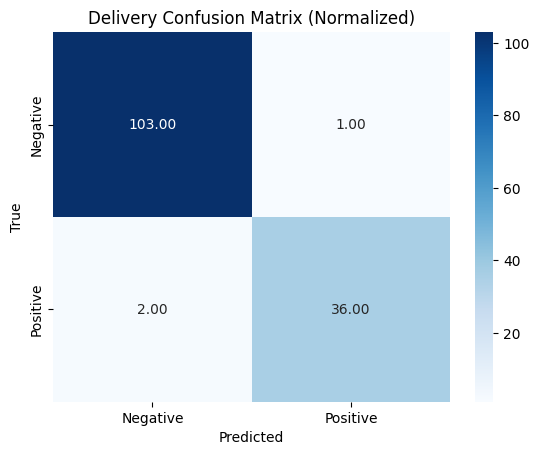

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(test_target, pred)
labels = ['Negative', 'Positive']  # 이진 분류 레이블
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
# title 에서 앞부분 본인 주제에 맞는 걸로 바꿔주세요.
plt.title('Delivery Confusion Matrix (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

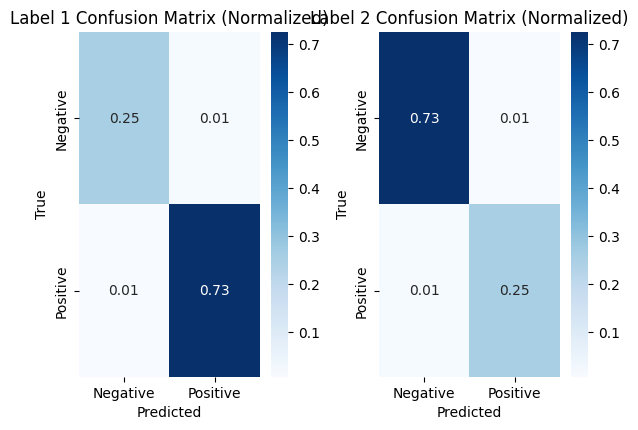

In [35]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
mcm = multilabel_confusion_matrix(test_target, pred)
# 정규화를 위해 각 행의 합으로 나누기
normalized_mcm = np.zeros_like(mcm, dtype=np.float32)
for i in range(mcm.shape[0]):
    row_sum = mcm[i].sum()
    if row_sum != 0:
        normalized_mcm[i] = mcm[i] / row_sum
# 혼동 행렬 시각화
plt.figure(figsize=(12, 8))
for i in range(normalized_mcm.shape[0]):
    plt.subplot(2, 4, i + 1)
    labels = ['Negative', 'Positive']  # 이진 분류 레이블
    sns.heatmap(normalized_mcm[i], annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Label {i + 1} Confusion Matrix (Normalized)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()